<a href="https://colab.research.google.com/github/TAUforPython/Graph-MachineLearning/blob/main/GCN%20genom%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Graph Convolutional Network for Population Classification

This notebook implements a GCN to classify population groups using genetic data
 1. Install required packages
 2. Load and preprocess data
 3. Construct k-NN graph using NetworkX
 4. Train GCN model
 5. Visualize results


Graph Convolutional Networks (GCNs) are particularly well-suited for this genetic population classification task for several compelling reasons that align perfectly with the nature of genetic data and population structure:

### 1. Genetic Data Has Inherent Graph Structure

Human genetic variation naturally forms a graph structure where:
- Individuals are nodes
- Genetic similarity forms edges between nodes
- Populations form natural clusters in this graph

When we constructed our k-NN graph, we observed clear community structure where individuals from the same population (like YRI, LWK, MSL) clustered together. GCNs directly leverage this structure rather than ignoring it (as traditional ML methods would).

### 2. Capturing Population Hierarchy

Human populations have a hierarchical structure that GCNs can effectively model:
- First GCN layer captures immediate genetic neighbors (within-population variation)
- Second GCN layer captures broader population structure (between-population relationships)
- This mirrors real human evolutionary history where populations diverge in a tree-like structure

Traditional classifiers treat all samples as independent, missing these critical hierarchical relationships that define population genetics.

### 3. Information Propagation Through Genetic Lineages

The core operation of GCNs - message passing - directly corresponds to how genetic information flows:
- Each individual's genetic profile is influenced by their ancestors
- GCNs propagate information from genetically similar individuals
- This creates a biologically meaningful smoothing effect where classification decisions incorporate information from related samples

This is particularly valuable for populations with limited samples, as information from genetically similar individuals improves classification accuracy.

### 4. Handling Small Sample Sizes per Population

In population genetics, we often have limited samples per population group (in our case, 7 populations with varying sample sizes). GCNs excel here because:

- They implement a form of semi-supervised learning where unlabeled nodes benefit from labeled neighbors
- Information propagates through the graph, effectively increasing the "effective sample size" for each individual
- This reduces overfitting compared to traditional methods that treat each sample in isolation

### 5. Modeling Linkage Disequilibrium

Genetic variants don't occur independently - nearby SNPs show correlation (linkage disequilibrium). While our current implementation uses a sample graph rather than a feature graph, the GCN approach naturally extends to model both:

- Sample relationships (who is genetically similar to whom)
- Feature relationships (which SNPs tend to co-occur)

This dual perspective is difficult to capture with traditional ML methods but aligns with biological reality.


### 6. Biological Interpretability

GCN representations often align with known population structure:
- The learned embeddings typically preserve geographic and historical relationships
- First GCN layer activations might highlight population-specific variants
- Second layer activations capture broader continental patterns

This interpretability is valuable for biological insights beyond just classification accuracy.

### 7. Practical Advantages for This Dataset

For our specific genetic dataset:
- The binary mutation encoding creates sparse features where traditional methods struggle
- Population boundaries are gradual (clinal variation) rather than discrete
- Genetic similarity forms a non-Euclidean manifold that graphs capture better than Euclidean distance


#Install and Load libraries

In [ ]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Determine the correct wheel URL based on PyTorch and CUDA versions
TORCH_VERSION = torch.__version__.split('+')[0]

# Format CUDA version correctly (e.g., 'cu118' for CUDA 11.8)
if torch.cuda.is_available():
    CUDA_VERSION = torch.version.cuda.replace('.', '')
    # Format as 'cu11x' where x is the minor version
    CUDA_VERSION = f"cu{CUDA_VERSION[:2]}{CUDA_VERSION[2]}"
else:
    CUDA_VERSION = 'cpu'

print(f"Installing for PyTorch {TORCH_VERSION} and {CUDA_VERSION}")

In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.4 MB/s eta 0:00:00


In [4]:
!pip install -q networkx

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(37)
np.random.seed(37)

#Load dataset

In [38]:

# ======================
# Data Loading & Preprocessing - OPTIMIZED
# ======================
def readAndProcessData():
    file_to_read = 'https://github.com/TAUforPython/BioMedAI/raw/refs/heads/main/test_datasets/gen_population_gender_dataset.txt'

    # FIX: Use raw string for regex to avoid escape sequence warning
    df = pd.read_csv(file_to_read, header=None, sep=r'\s+')
    gender = df[1]
    population = df[2]
    print("Unique populations:", np.unique(population))

    # Drop ID, gender, and population columns
    df.drop(df.columns[[0, 1, 2]], axis=1, inplace=True)

    # Get modes for each column (most frequent value)
    modes = df.mode().iloc[0]

    # Vectorized binary encoding: 0 if value equals mode, 1 if it's a mutation
    # This avoids DataFrame fragmentation by processing all columns at once
    df_encoded = (df != modes).astype(int)

    return df_encoded, modes, population, gender

df, modes, population, gender = readAndProcessData()

# Preprocess target variable
le = LabelEncoder()
y = le.fit_transform(population)
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print("Class mapping:", dict(zip(range(num_classes), le.classes_)))

# No need for StandardScaler since data is already binary (0/1)
X = df.values.astype(float)

Unique populations: ['ACB' 'ASW' 'ESN' 'GWD' 'LWK' 'MSL' 'YRI']
Number of classes: 7
Class mapping: {0: 'ACB', 1: 'ASW', 2: 'ESN', 3: 'GWD', 4: 'LWK', 5: 'MSL', 6: 'YRI'}


# Visualise dataset

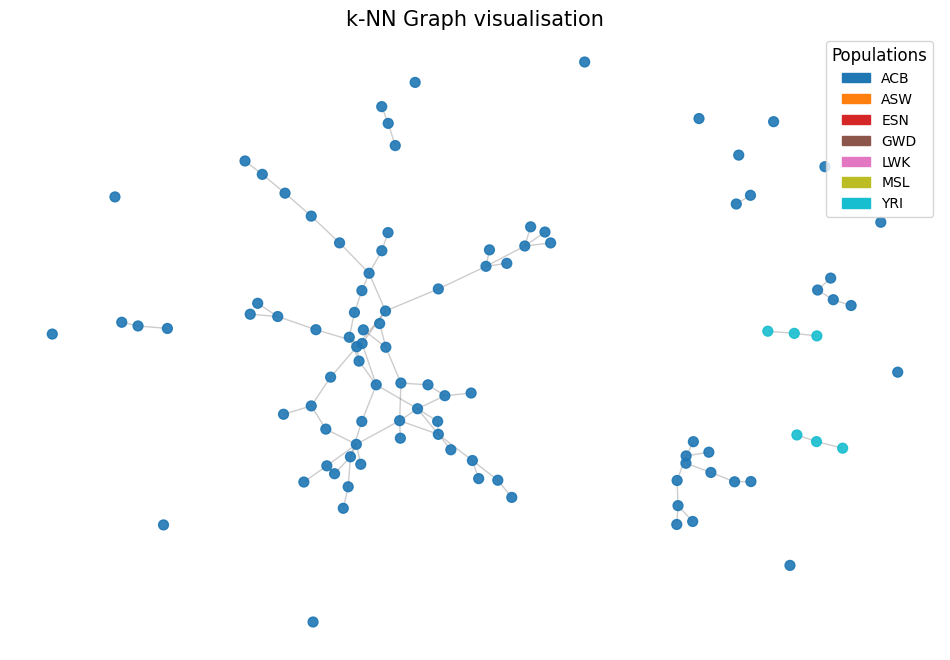

In [46]:
# Graph Construction (k-NN)

from sklearn.neighbors import kneighbors_graph
import matplotlib.patches as mpatches # Import mpatches for custom legend handles

# Create k-NN graph (k=5)
k = 5
adj_matrix = kneighbors_graph(X, k, mode='connectivity', include_self=False)

# Convert to NetworkX graph
G = nx.from_scipy_sparse_array(adj_matrix)

number_visualise_nodes = 100

# Visualize a subgraph (first 50 nodes) for clarity
plt.figure(figsize=(12, 8))
# Create a subgraph from the first 50 nodes
G_sub = G.subgraph(range(number_visualise_nodes))
# Compute positions only for the nodes in the subgraph
pos = nx.spring_layout(G_sub, seed=37)
nx.draw_networkx_nodes(G_sub, pos, node_size=50,
                       node_color=y[:number_visualise_nodes],
                       cmap='tab10',
                       alpha=0.9)
nx.draw_networkx_edges(G_sub, pos, alpha=0.2)
plt.title('k-NN Graph visualisation', fontsize=15)
plt.axis('off')

# Create legend patches using the same colormap and encoded labels
# le.classes_ and num_classes are available from the previous data loading cell
population_colors = plt.cm.tab10(np.linspace(0, 1, num_classes))
legend_patches = [mpatches.Patch(color=population_colors[i], label=le.classes_[i])
                 for i in range(num_classes)]
plt.legend(handles=legend_patches, title="Populations", loc='best', fontsize=10, title_fontsize=12)

plt.show()

In [48]:
from scipy.spatial.distance import pdist, squareform
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

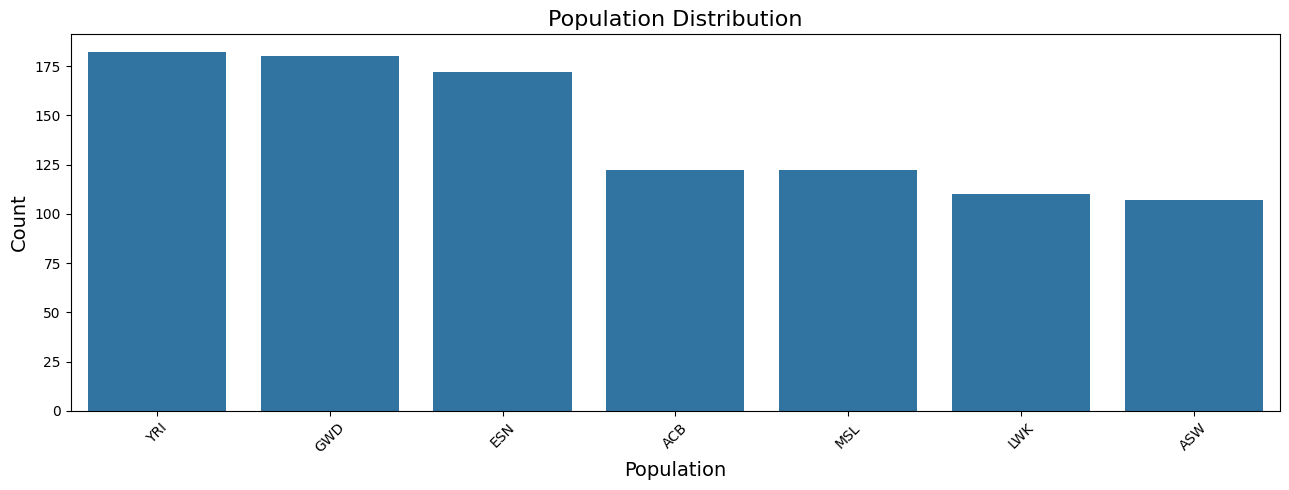

In [54]:
# ======================
# Visualize Population Distribution
# ======================
plt.figure(figsize=(13, 5))
population_counts = population.value_counts()
sns.barplot(x=population_counts.index, y=population_counts.values)
plt.title('Population Distribution', fontsize=16)
plt.xlabel('Population', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

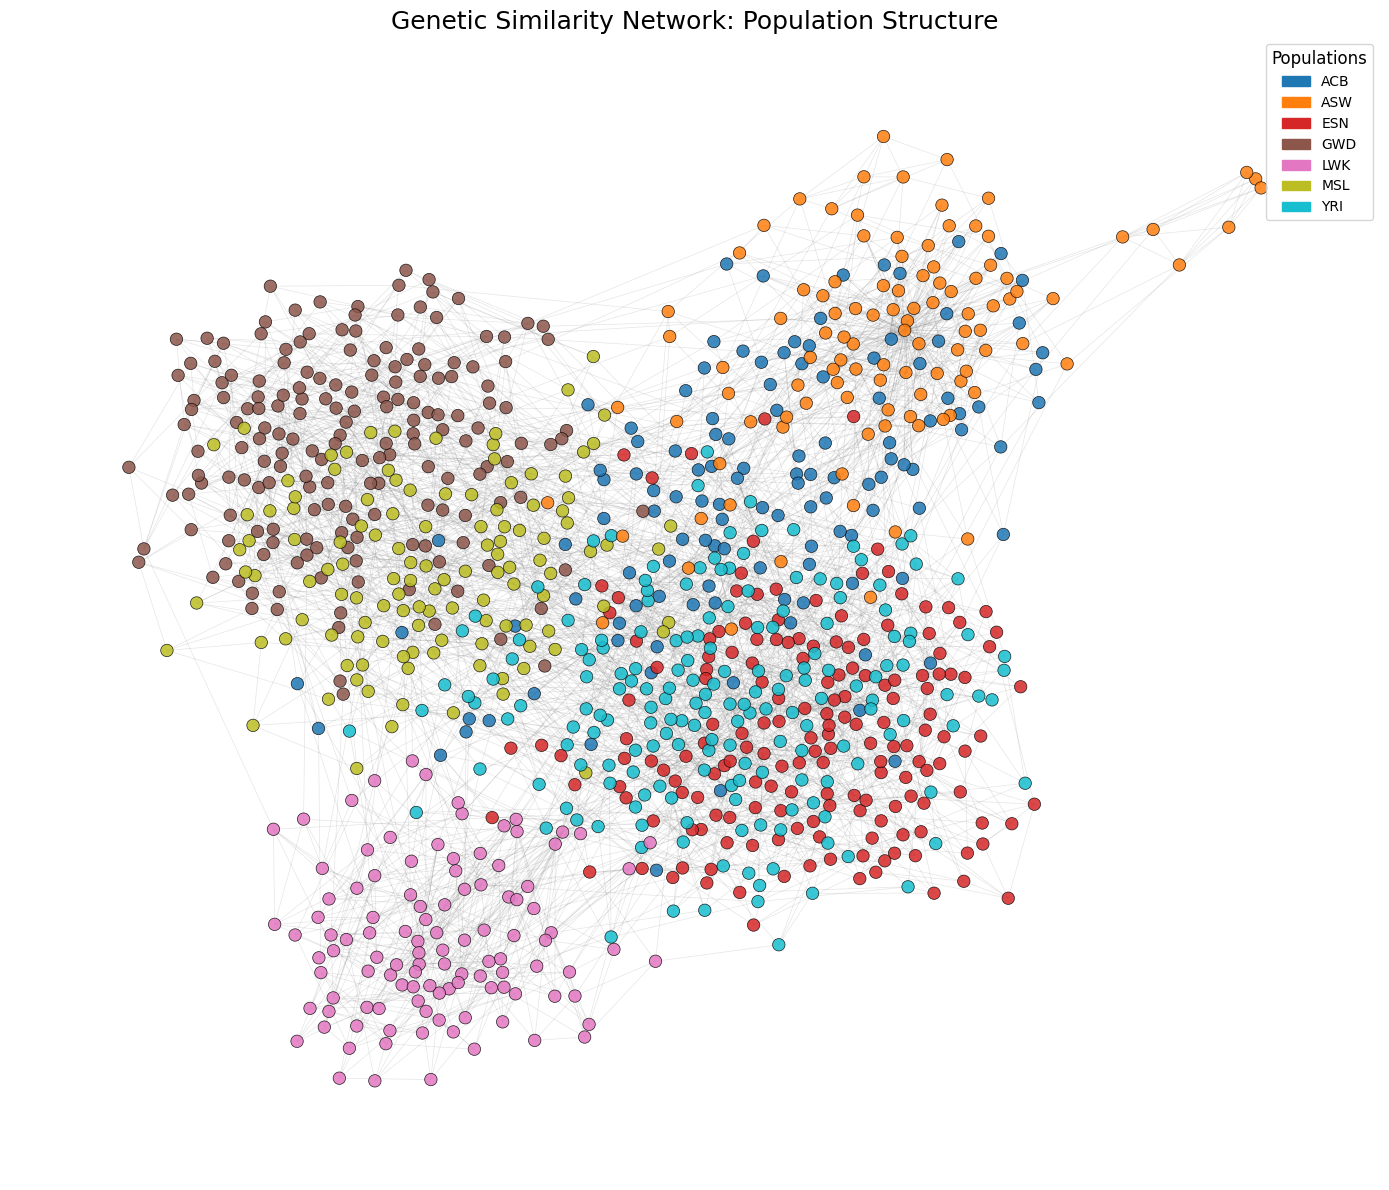

In [55]:

# ======================
# Create Genetic Similarity Graph
# ======================
# Convert to numpy array for processing
X = df.values.astype(float)

# Calculate pairwise genetic distances (Hamming distance)
distances = pdist(X, metric='hamming')
similarity_matrix = 1 - squareform(distances)

# Create k-NN graph (k=5) based on genetic similarity
k = 5
adj_matrix = kneighbors_graph(X, k, mode='connectivity', include_self=False)

# Convert to NetworkX graph
G = nx.from_scipy_sparse_array(adj_matrix)

# Encode populations for coloring
le = LabelEncoder()
pop_encoded = le.fit_transform(population)
pop_classes = le.classes_
num_classes = len(pop_classes)

# Create a color map for populations
population_colors = plt.cm.tab10(np.linspace(0, 1, num_classes))
population_color_dict = {pop: population_colors[i] for i, pop in enumerate(pop_classes)}

# Map colors to nodes
node_colors = [population_color_dict[population[i]] for i in range(len(population))]

# %% [code]
# ======================
# Visualization 1: Force-Directed Graph Layout
# ======================
plt.figure(figsize=(14, 12))

# Use a force-directed layout that emphasizes community structure
pos = nx.spring_layout(G, k=0.3, iterations=100, seed=37)

# Draw the graph
nx.draw_networkx_nodes(
    G, pos,
    node_size=80,
    node_color=node_colors,
    alpha=0.85,
    edgecolors='black',
    linewidths=0.5
)
nx.draw_networkx_edges(
    G, pos,
    width=0.5,
    alpha=0.2,
    edge_color='gray'
)

# Create legend
legend_patches = [mpatches.Patch(color=population_colors[i], label=pop_classes[i])
                 for i in range(num_classes)]
plt.legend(handles=legend_patches, title="Populations",
           loc='best', fontsize=10, title_fontsize=12)

plt.title('Genetic Similarity Network: Population Structure', fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.savefig('genetic_similarity_network.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipython-input-1759067565.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_classes)


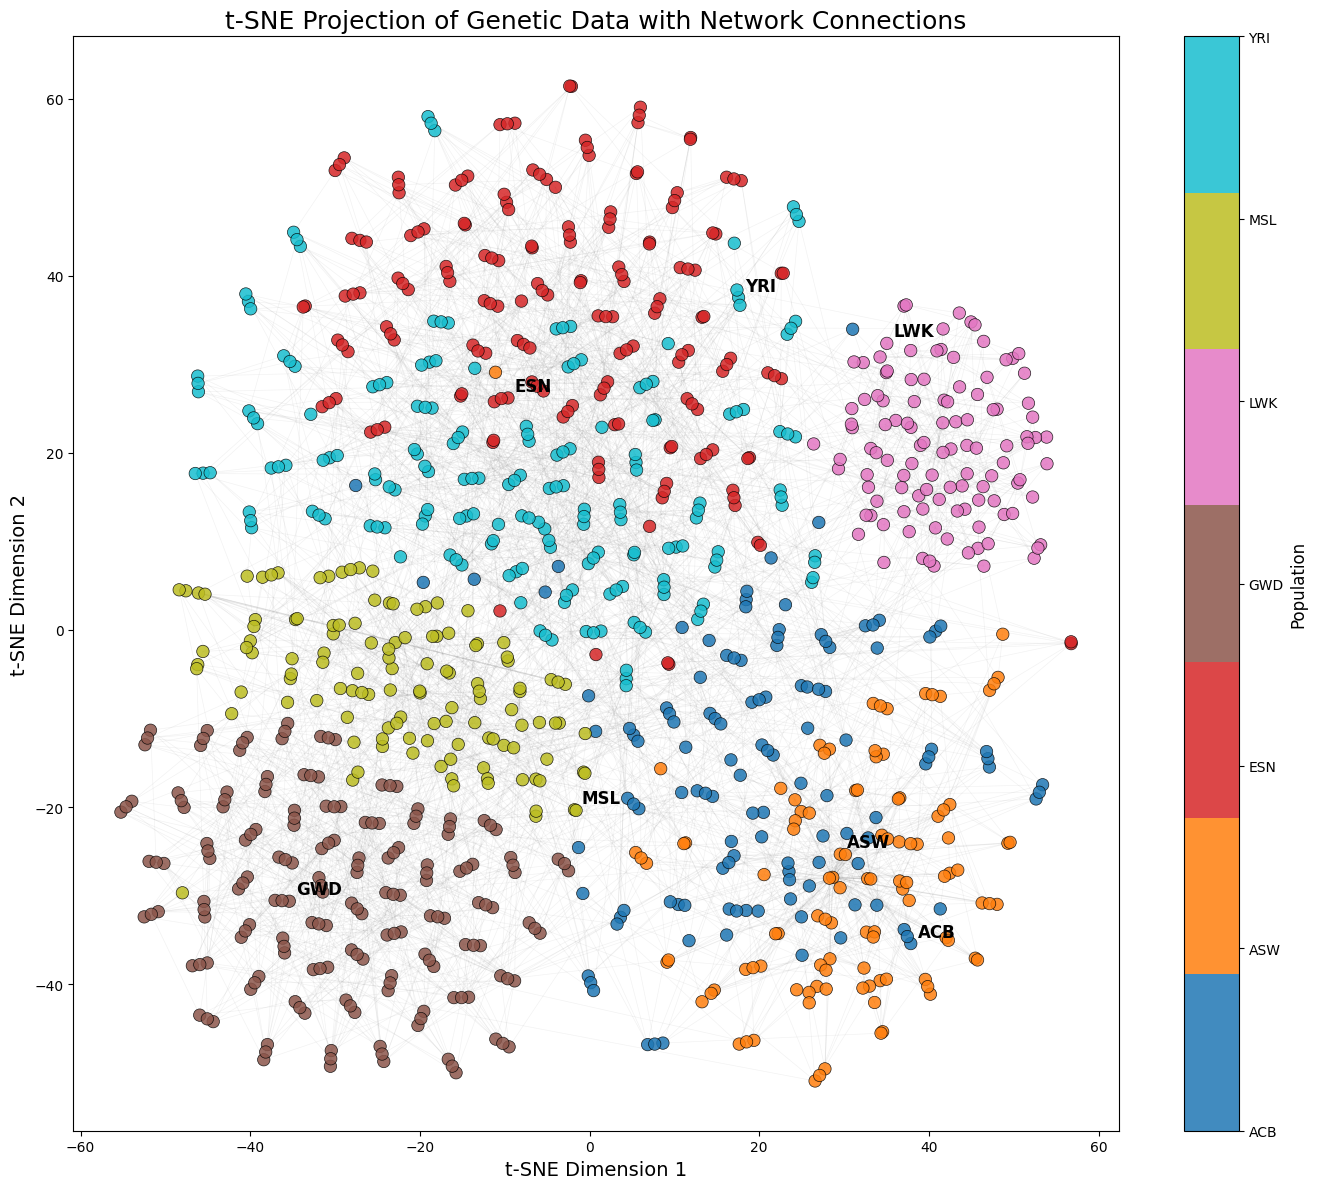

In [56]:
# ======================
# Visualization 2: t-SNE Projection with Network Overlay
# ======================
from sklearn.manifold import TSNE
# Compute t-SNE embedding of the genetic data
tsne = TSNE(n_components=2, random_state=37, perplexity=30)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(14, 12))

# Create a custom colormap with higher contrast
cmap = plt.cm.get_cmap('tab10', num_classes)

# Plot points colored by population
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=pop_encoded,
    cmap=cmap,
    s=80,
    alpha=0.85,
    edgecolor='black',
    linewidth=0.5,
    zorder=2
)

# Draw edges from the k-NN graph
for edge in G.edges():
    i, j = edge
    plt.plot(
        [X_tsne[i, 0], X_tsne[j, 0]],
        [X_tsne[i, 1], X_tsne[j, 1]],
        'gray', alpha=0.1, linewidth=0.5, zorder=1
    )

# Add population labels for some representative points
for pop in pop_classes:
    idx = np.where(population == pop)[0][0]  # First individual of each population
    plt.annotate(
        pop,
        (X_tsne[idx, 0], X_tsne[idx, 1]),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=12,
        fontweight='bold'
    )

# Add a colorbar/legend
cbar = plt.colorbar(scatter, ticks=range(num_classes))
cbar.set_ticklabels(pop_classes)
cbar.set_label('Population', fontsize=12)

plt.title('t-SNE Projection of Genetic Data with Network Connections', fontsize=18)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)
plt.tight_layout()
plt.savefig('tsne_with_network.png', dpi=300, bbox_inches='tight')
plt.show()


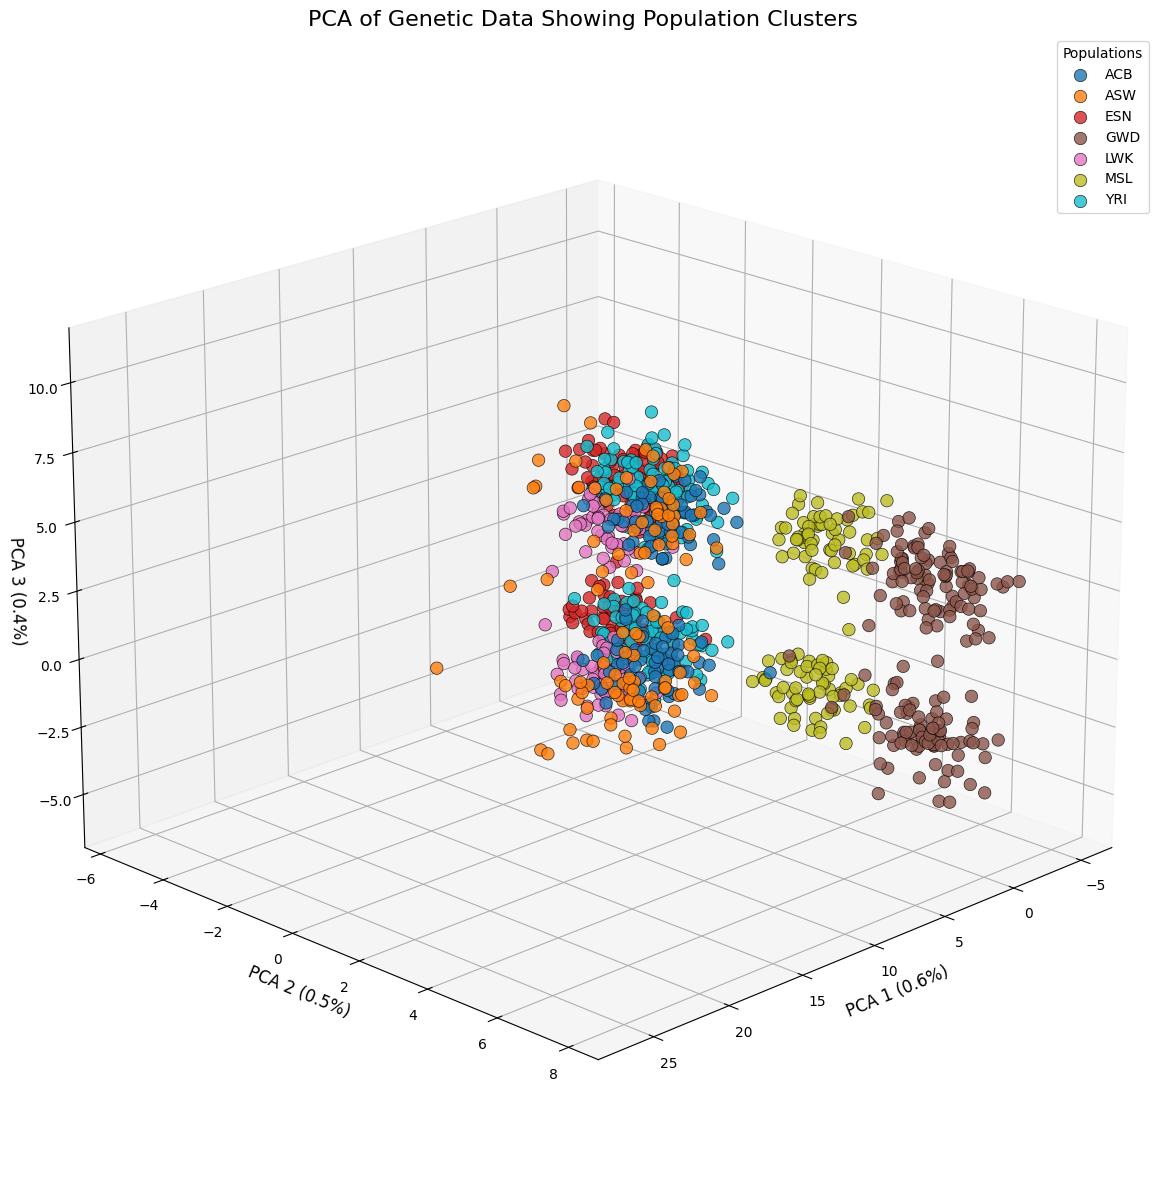

In [57]:
# ======================
# Visualization 3: PCA with Population Clusters
# ======================
from sklearn.decomposition import PCA
# Perform PCA on the genetic data
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create a 3D plot
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot points colored by population
for i, pop in enumerate(pop_classes):
    idx = np.where(population == pop)[0]
    ax.scatter(
        X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2],
        c=[population_colors[i]],
        label=pop,
        s=80,
        alpha=0.8,
        edgecolor='black',
        linewidth=0.5
    )

# Add axis labels and title
ax.set_xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax.set_ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax.set_zlabel(f'PCA 3 ({pca.explained_variance_ratio_[2]:.1%})', fontsize=12)
ax.set_title('PCA of Genetic Data Showing Population Clusters', fontsize=16)

# Add legend
ax.legend(title="Populations", loc='best')

# Adjust view angle for better visibility
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.savefig('pca_3d.png', dpi=300, bbox_inches='tight')
plt.show()


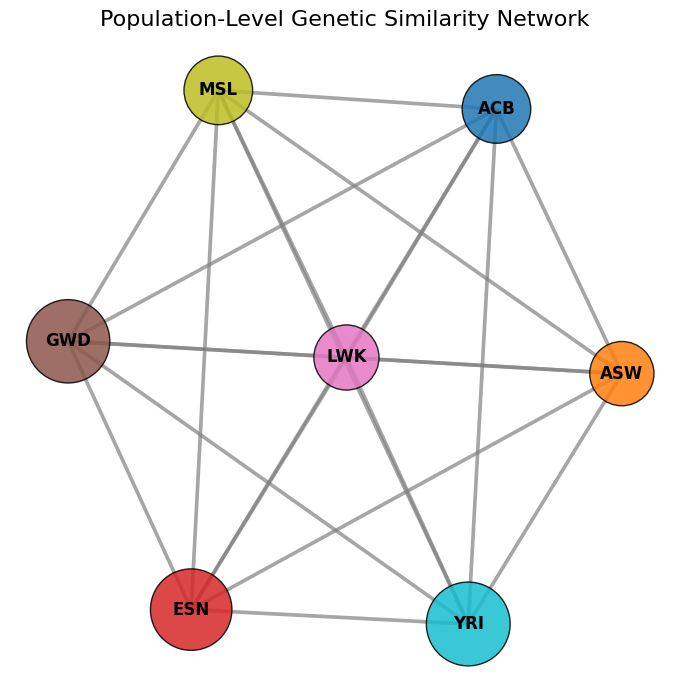

In [60]:
# ======================
# Visualization 4: Population Network with Edge Weights
# ======================
# Create a population-level network
pop_similarity = np.zeros((num_classes, num_classes))

# Calculate average similarity between populations
for i in range(num_classes):
    for j in range(num_classes):
        pop_i_idx = np.where(population == pop_classes[i])[0]
        pop_j_idx = np.where(population == pop_classes[j])[0]

        # Calculate average similarity between the two populations
        if len(pop_i_idx) > 0 and len(pop_j_idx) > 0:
            pop_similarity[i, j] = np.mean(similarity_matrix[np.ix_(pop_i_idx, pop_j_idx)])

# Create population network
pop_G = nx.Graph()
for i in range(num_classes):
    pop_G.add_node(i, population=pop_classes[i], size=len(np.where(population == pop_classes[i])[0]))

# Add edges with weights based on similarity
for i in range(num_classes):
    for j in range(i+1, num_classes):
        weight = pop_similarity[i, j]
        if weight > 0.52:  # Only show strong connections - Adjusted threshold
            pop_G.add_edge(i, j, weight=weight)

# Create layout for population network
pop_pos = nx.spring_layout(pop_G, seed=42)

plt.figure(figsize=(7, 7))

# Draw nodes with size proportional to population sample size
node_sizes = [pop_G.nodes[i]['size'] * 20 for i in pop_G.nodes()]
nx.draw_networkx_nodes(
    pop_G, pop_pos,
    node_size=node_sizes,
    node_color=[population_colors[i] for i in pop_G.nodes()],
    alpha=0.85,
    edgecolors='black',
    linewidths=1
)

# Draw edges with width proportional to similarity
edge_weights = [pop_G[u][v]['weight'] * 5 for u, v in pop_G.edges()]
nx.draw_networkx_edges(
    pop_G, pop_pos,
    width=edge_weights,
    alpha=0.7,
    edge_color='gray'
)

# Add labels
node_labels = {i: pop_classes[i] for i in pop_G.nodes()}
nx.draw_networkx_labels(pop_G, pop_pos, labels=node_labels, font_size=12, font_weight='bold')

plt.title('Population-Level Genetic Similarity Network', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig('population_network.png', dpi=300, bbox_inches='tight')
plt.show()

# Main code

In [72]:
# ======================
# Prepare PyTorch Geometric Data
# ======================
# Convert to PyTorch Geometric Data format
data = Data(
    x=torch.tensor(X, dtype=torch.float),
    edge_index=torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long),
    y=torch.tensor(y, dtype=torch.long)
)

# Create train/test split (80/20) and a validation split (10%) from training data
train_idx, test_idx = train_test_split(
    np.arange(len(y)),
    test_size=0.2,
    random_state=37,
    stratify=y
)
train_idx, val_idx = train_test_split(
    train_idx,
    test_size=0.125, # 0.125 * 0.8 = 0.1 of total data
    random_state=37,
    stratify=y[train_idx]
)

# Create masks for PyG
data.train_mask = torch.zeros(len(y), dtype=torch.bool)
data.val_mask = torch.zeros(len(y), dtype=torch.bool)
data.test_mask = torch.zeros(len(y), dtype=torch.bool)
data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

print(f"Training samples: {data.train_mask.sum()}")
print(f"Validation samples: {data.val_mask.sum()}")
print(f"Testing samples: {data.test_mask.sum()}")

# ======================
# GCN Model Definition
# ======================
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, num_layers=2):
        super(GCN, self).__init__()
        self.num_layers = num_layers
        self.conv_layers = torch.nn.ModuleList()

        # First layer
        self.conv_layers.append(GCNConv(num_node_features, hidden_channels))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.conv_layers.append(GCNConv(hidden_channels, hidden_channels))

        # Output layer
        if num_layers > 1:
            self.conv_layers.append(GCNConv(hidden_channels, num_classes))
        else: # Case for a single layer GCN
            self.conv_layers.append(GCNConv(num_node_features, num_classes))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i, conv in enumerate(self.conv_layers):
            x = conv(x, edge_index)
            if i < len(self.conv_layers) - 1: # Apply activation and dropout to all but the last layer
                x = F.elu(x) # Using ELU activation
                x = F.dropout(x, p=0.5, training=self.training)

        return F.log_softmax(x, dim=1)

# Calculate class weights for imbalanced dataset
class_counts = np.bincount(y)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum() * num_classes # Normalize weights
print("Class counts:", class_counts)
print("Class weights (normalized):\n", class_weights)

# Initialize model, optimizer, and criterion
model = GCN(
    num_node_features=X.shape[1],
    hidden_channels=256,
    num_classes=num_classes,
    num_layers=3 # Example: 3-layer GCN
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights) # Apply class weights

# ======================
# Model Training
# ======================
from sklearn.metrics import f1_score

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out[mask].argmax(dim=1)
        true_labels = data.y[mask]

        # Calculate accuracy
        acc = int((pred == true_labels).sum()) / int(mask.sum())

        # Calculate F1 score (macro average for multi-class)
        f1 = f1_score(true_labels.cpu().numpy(), pred.cpu().numpy(), average='macro', zero_division=0)
        return acc, f1

# Training loop
best_val_f1 = 0
train_f1_scores = []
val_f1_scores = []

epochs_without_improvement = 10
patience = 180 # Early stopping patience

print("\nStarting training...")
for epoch in range(1, 251):
    loss = train()
    train_acc, train_f1 = evaluate(data.train_mask)
    val_acc, val_f1 = evaluate(data.val_mask)

    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_gcn_model_f1.pth') # Save best model based on F1
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epoch % 20 == 0 or epochs_without_improvement > patience:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '+
              f'Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, '+
              f'Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

    if epochs_without_improvement > patience:
        print(f"Early stopping triggered after {patience} epochs without improvement.")
        break

print(f"\nBest Validation F1 Score: {best_val_f1:.4f}")

# Load best model for final evaluation
model.load_state_dict(torch.load('best_gcn_model_f1.pth'))
model.eval()

Training samples: 696
Validation samples: 100
Testing samples: 199
Class counts: [122 107 172 180 110 122 182]
Class weights (normalized):
 tensor([1.1099, 1.2655, 0.7873, 0.7523, 1.2310, 1.1099, 0.7440])

Starting training...
Epoch: 020, Loss: 3.6161, Train Acc: 0.1250, Train F1: 0.0347, Val Acc: 0.1200, Val F1: 0.0306
Epoch: 040, Loss: 1.6811, Train Acc: 0.3175, Train F1: 0.2779, Val Acc: 0.3300, Val F1: 0.3050
Epoch: 060, Loss: 1.0976, Train Acc: 0.6911, Train F1: 0.6661, Val Acc: 0.6700, Val F1: 0.6574
Epoch: 080, Loss: 0.7934, Train Acc: 0.7356, Train F1: 0.7129, Val Acc: 0.6900, Val F1: 0.6802
Epoch: 100, Loss: 0.8025, Train Acc: 0.7342, Train F1: 0.7225, Val Acc: 0.7200, Val F1: 0.7066
Epoch: 120, Loss: 0.6441, Train Acc: 0.7859, Train F1: 0.7823, Val Acc: 0.7400, Val F1: 0.7375
Epoch: 140, Loss: 0.5044, Train Acc: 0.8664, Train F1: 0.8717, Val Acc: 0.7700, Val F1: 0.7656
Epoch: 160, Loss: 0.5566, Train Acc: 0.7443, Train F1: 0.7319, Val Acc: 0.6500, Val F1: 0.6141
Epoch: 180, L

GCN(
  (conv_layers): ModuleList(
    (0): GCNConv(10101, 256)
    (1): GCNConv(256, 256)
    (2): GCNConv(256, 7)
  )
)

#Classification visualisation


Test Accuracy: 0.7889
Test F1 Score (Macro): 0.7885


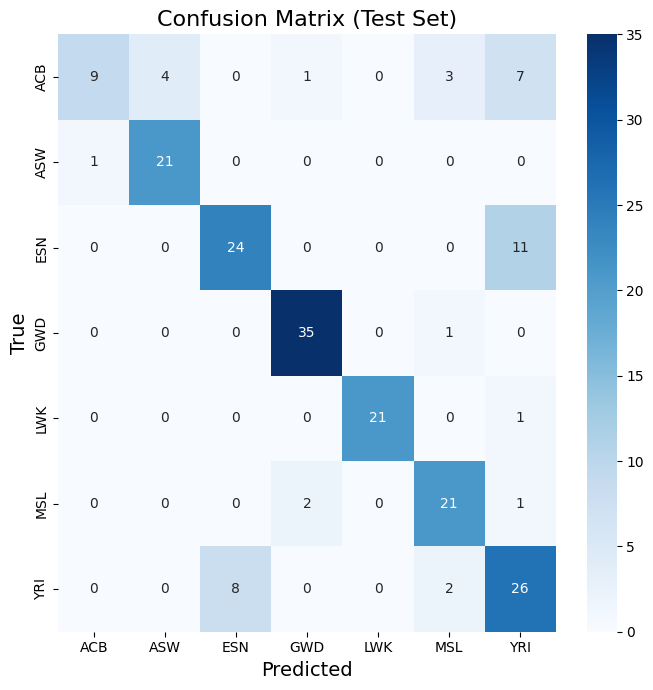

Classification Report (Test Set):
              precision    recall  f1-score   support

         ACB       0.90      0.38      0.53        24
         ASW       0.84      0.95      0.89        22
         ESN       0.75      0.69      0.72        35
         GWD       0.92      0.97      0.95        36
         LWK       1.00      0.95      0.98        22
         MSL       0.78      0.88      0.82        24
         YRI       0.57      0.72      0.63        36

    accuracy                           0.79       199
   macro avg       0.82      0.79      0.79       199
weighted avg       0.81      0.79      0.78       199



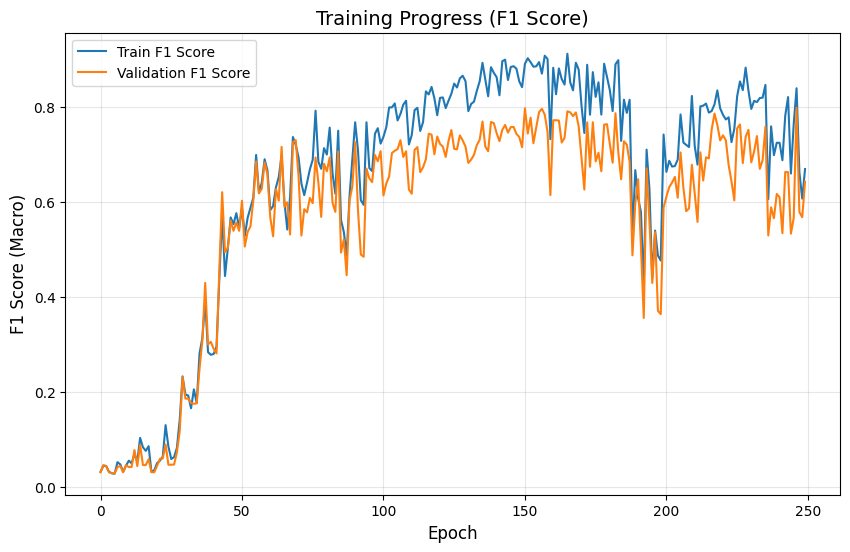

In [73]:
# ======================
# Evaluation & Visualization
# ======================
# Get predictions on the test set
out = model(data)
pred = out.argmax(dim=1).detach().numpy()

# Evaluate on test set
test_acc, test_f1 = evaluate(data.test_mask)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test F1 Score (Macro): {test_f1:.4f}")

# Confusion Matrix
plt.figure(figsize=(7, 7))
cm = confusion_matrix(y[data.test_mask], pred[data.test_mask])
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix (Test Set)', fontsize=16)
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report (Test Set):")
print(classification_report(
    y[data.test_mask],
    pred[data.test_mask],
    target_names=le.classes_,
    zero_division=0 # Handle cases where no predictions are made for a class
))

# Training Progress (F1 Scores)
plt.figure(figsize=(10, 6))
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('F1 Score (Macro)', fontsize=12)
plt.title('Training Progress (F1 Score)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Analyse GCN improvement
GCN hidden channels experiment using `[64, 128, 256]` for hidden channels.

In [70]:
df, modes, population, gender = readAndProcessData()

# Preprocess target variable
le = LabelEncoder()
y = le.fit_transform(population)
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print("Class mapping:", dict(zip(range(num_classes), le.classes_)))

# No need for StandardScaler since data is already binary (0/1)
X = df.values.astype(float)

# ======================
# Create Genetic Similarity Graph (using k-NN graph construction as before)
# ======================
from sklearn.neighbors import kneighbors_graph

k = 5 # As defined in previous cells
adj_matrix = kneighbors_graph(X, k, mode='connectivity', include_self=False)

# ======================
# Prepare PyTorch Geometric Data
# ======================
# Convert to PyTorch Geometric Data format
data = Data(
    x=torch.tensor(X, dtype=torch.float),
    edge_index=torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long),
    y=torch.tensor(y, dtype=torch.long)
)

# Create train/test split (80/20) and a validation split (10%) from training data
train_idx, test_idx = train_test_split(
    np.arange(len(y)),
    test_size=0.2,
    random_state=37,
    stratify=y
)
train_idx, val_idx = train_test_split(
    train_idx,
    test_size=0.125, # 0.125 * 0.8 = 0.1 of total data
    random_state=37,
    stratify=y[train_idx]
)

# Create masks for PyG
data.train_mask = torch.zeros(len(y), dtype=torch.bool)
data.val_mask = torch.zeros(len(y), dtype=torch.bool)
data.test_mask = torch.zeros(len(y), dtype=torch.bool)
data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

print(f"Training samples: {data.train_mask.sum()}")
print(f"Validation samples: {data.val_mask.sum()}")
print(f"Testing samples: {data.test_mask.sum()}")

# ======================
# GCN Model Definition
# ======================
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, num_layers=2):
        super(GCN, self).__init__()
        self.num_layers = num_layers
        self.conv_layers = torch.nn.ModuleList()

        # First layer
        self.conv_layers.append(GCNConv(num_node_features, hidden_channels))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.conv_layers.append(GCNConv(hidden_channels, hidden_channels))

        # Output layer
        if num_layers > 1:
            self.conv_layers.append(GCNConv(hidden_channels, num_classes))
        else: # Case for a single layer GCN
            self.conv_layers.append(GCNConv(num_node_features, num_classes))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i, conv in enumerate(self.conv_layers):
            x = conv(x, edge_index)
            if i < len(self.conv_layers) - 1: # Apply activation and dropout to all but the last layer
                x = F.elu(x) # Using ELU activation
                x = F.dropout(x, p=0.5, training=self.training)

        return F.log_softmax(x, dim=1)

# Calculate class weights for imbalanced dataset
class_counts = np.bincount(y)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum() * num_classes # Normalize weights
print("Class counts:", class_counts)
print("Class weights (normalized):\n", class_weights)

# ======================
# Model Training Function
# ======================
def train_gcn_model(model_instance, optimizer_instance, criterion_instance, data_instance, num_epochs=251, patience=180):
    best_val_f1_for_this_run = 0
    epochs_without_improvement = 0
    best_model_state_dict = None

    train_f1_scores = []
    val_f1_scores = []

    print(f"\nStarting training for hidden_channels={model_instance.conv_layers[0].out_channels}...")
    for epoch in range(1, num_epochs):
        model_instance.train()
        optimizer_instance.zero_grad()
        out = model_instance(data_instance)
        loss = criterion_instance(out[data_instance.train_mask], data_instance.y[data_instance.train_mask])
        loss.backward()
        optimizer_instance.step()

        train_acc, train_f1 = evaluate(model_instance, data_instance, data_instance.train_mask)
        val_acc, val_f1 = evaluate(model_instance, data_instance, data_instance.val_mask)

        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        if val_f1 > best_val_f1_for_this_run:
            best_val_f1_for_this_run = val_f1
            best_model_state_dict = model_instance.state_dict() # Capture state_dict
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epoch % 50 == 0 or epochs_without_improvement > patience:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '+
                  f'Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, '+
                  f'Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

        if epochs_without_improvement > patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    return best_val_f1_for_this_run, best_model_state_dict, train_f1_scores, val_f1_scores

def evaluate(model_instance, data_instance, mask):
    model_instance.eval()
    with torch.no_grad():
        out = model_instance(data_instance)
        pred = out[mask].argmax(dim=1)
        true_labels = data_instance.y[mask]

        # Calculate accuracy
        acc = int((pred == true_labels).sum()) / int(mask.sum())

        # Calculate F1 score (macro average for multi-class)
        f1 = f1_score(true_labels.cpu().numpy(), pred.cpu().numpy(), average='macro', zero_division=0)
        return acc, f1

# ======================
# Experiment with Hidden Channels
# ======================
hidden_channels_options = [64, 128, 256]
results = {}

best_overall_val_f1 = -1
best_hidden_channels = None
best_overall_model_state_dict = None # To store the state_dict of the truly best model

for hc in hidden_channels_options:
    print(f"\n--- Testing hidden_channels = {hc} ---")
    # Initialize model, optimizer, and criterion for each run
    current_model = GCN(
        num_node_features=X.shape[1],
        hidden_channels=hc,
        num_classes=num_classes,
        num_layers=2 # Keep num_layers consistent for now
    )
    current_optimizer = torch.optim.Adam(current_model.parameters(), lr=0.01, weight_decay=5e-4)
    current_criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

    # train_gcn_model now returns the best_val_f1 and state_dict for THIS run
    val_f1_for_current_hc, current_best_state_dict, train_f1_scores_history, val_f1_scores_history = \
        train_gcn_model(current_model, current_optimizer, current_criterion, data)

    results[hc] = {
        'val_f1': val_f1_for_current_hc,
        'train_f1_history': train_f1_scores_history,
        'val_f1_history': val_f1_scores_history
    }

    if val_f1_for_current_hc > best_overall_val_f1:
        best_overall_val_f1 = val_f1_for_current_hc
        best_hidden_channels = hc
        best_overall_model_state_dict = current_best_state_dict # Store the state_dict
        # Optionally, save this state_dict to a file immediately
        torch.save(best_overall_model_state_dict, 'best_overall_gcn_model.pth')

print("\n======================================")
print("Experiment Results:")
for hc, res in results.items():
    print(f"Hidden Channels: {hc}, Best Validation F1: {res['val_f1']:.4f}")

print("\nBest hidden_channels found:", best_hidden_channels)
print(f"Best overall Validation F1 Score: {best_overall_val_f1:.4f}")

# Final Evaluation with the truly best model
if best_hidden_channels is not None and best_overall_model_state_dict is not None:
    final_model = GCN(
        num_node_features=X.shape[1],
        hidden_channels=best_hidden_channels, # Initialize with the best hc
        num_classes=num_classes,
        num_layers=2
    )
    # Load the state_dict that corresponds to the best_hidden_channels
    final_model.load_state_dict(best_overall_model_state_dict)
    final_model.eval()

    test_acc, test_f1 = evaluate(final_model, data, data.test_mask)
    print(f"\nFinal Test Accuracy with best hidden_channels ({best_hidden_channels}): {test_acc:.4f}")
    print(f"Final Test F1 Score (Macro) with best hidden_channels ({best_hidden_channels}): {test_f1:.4f}")

    # Store the best model configuration for later use if needed
    best_model_params = {
        'num_node_features': X.shape[1],
        'hidden_channels': best_hidden_channels,
        'num_classes': num_classes,
        'num_layers': 2
    }
    print(f"Best model (with {best_hidden_channels} hidden channels) state dictionary was saved to 'best_overall_gcn_model.pth'.")
else:
    print("No best model found or state dictionary is None.")

Unique populations: ['ACB' 'ASW' 'ESN' 'GWD' 'LWK' 'MSL' 'YRI']
Number of classes: 7
Class mapping: {0: 'ACB', 1: 'ASW', 2: 'ESN', 3: 'GWD', 4: 'LWK', 5: 'MSL', 6: 'YRI'}
Training samples: 696
Validation samples: 100
Testing samples: 199
Class counts: [122 107 172 180 110 122 182]
Class weights (normalized):
 tensor([1.1099, 1.2655, 0.7873, 0.7523, 1.2310, 1.1099, 0.7440])

--- Testing hidden_channels = 64 ---

Starting training for hidden_channels=64...
Epoch: 050, Loss: 2.1381, Train Acc: 0.1236, Train F1: 0.0314, Val Acc: 0.1200, Val F1: 0.0306
Epoch: 100, Loss: 2.0487, Train Acc: 0.1106, Train F1: 0.0568, Val Acc: 0.1400, Val F1: 0.0725
Epoch: 150, Loss: 2.0957, Train Acc: 0.1552, Train F1: 0.0635, Val Acc: 0.2000, Val F1: 0.0878
Epoch: 182, Loss: 2.0438, Train Acc: 0.1178, Train F1: 0.0493, Val Acc: 0.1100, Val F1: 0.0387
Early stopping triggered after 180 epochs without improvement.

--- Testing hidden_channels = 128 ---

Starting training for hidden_channels=128...
Epoch: 050, L

## Experiment Results Summary

The GCN hidden channel experiment was run with `hidden_channels_options = [64, 128, 256]`.

### Best Configuration:
- **Best Hidden Channels:** 256
- **Best Overall Validation F1 Score:** 0.8426

### Final Test Metrics for the Best Model (Hidden Channels = 256):
- **Final Test Accuracy:** 0.8945
- **Final Test F1 Score (Macro):** 0.8998